# Wstęp do Sztucznej Inteligencji - rok akademicki 2020/2021

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `NrAlbumu_Nazwisko_Imie_PoprzedniaNazwa`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia.

## Biblioteka Keras. Sieci konwolucyjne.
Zapoznaj się z treścią niniejszego notatnika czytając i wykonując go komórka po komórce. Wykonaj napotkane zadania/ćwiczenia.

Keras: https://keras.io/

TensorFlow: https://www.tensorflow.org/

__Uwaga!__
Trenowanie przykładowych sieci w tym notatniku jest wymagające obliczeniowo. W razie problemów, skorzystaj z załączonych pretrenowanych modeli (pliki \*.hdf5).

### Sprawdź swoją konfigurację

In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


## Baza MNIST
Baza MNIST zawiera zbiór trenujący składający się z 60,000 przykładów skanów ręcznie pisanych cyfr od 0 do 9 (problem klasyfikacyjny z 10 klasami). 

Zbiór testowy zawiera 10,000 przykładów.

Każdy obraz ma rozmiar 28x28 pikseli. Stanowią one 28 * 28 = 784 wejść do sieci.

W zagadnieniach rozpoznawania obrazów baza MNIST pełni rolę swoistego problemu `Hello world`.

Przeczytaj więcej o bazie MNIST:

http://yann.lecun.com/exdb/mnist/

### Pobranie bazy MNIST

Baza MNIST może być pobrana w wersji binarnej bezpośrednio ze strony
http://yann.lecun.com/exdb/mnist/

W formie plików \*.csv baza MNIST jest dostępna na stronie

https://pjreddie.com/projects/mnist-in-csv/

Najwygodniej jednak użyć importu bazy MNIST z wykorzystaniem biblioteki Keras. Przy pierwszym imporcie baza ta zostanie pobrana automatycznie (ok. 12MB). Umieszczona zostanie w katalogu `~/.keras/datasets/mnist.pkl.gz`.

Poniżej znajduje się przykładowy kod wczytujący dane trenujące i testowe, oraz wyświetlający kilka przykładowych obrazów.

11501568/11490434 [==============================] - 0s 0us/step
xtrain.shape (60000, 28, 28)
ytrain.shape (60000,)
xtest.shape (10000, 28, 28)
ytest.shape (10000,)


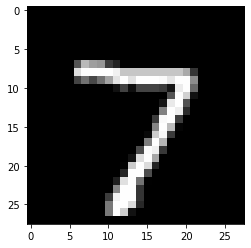

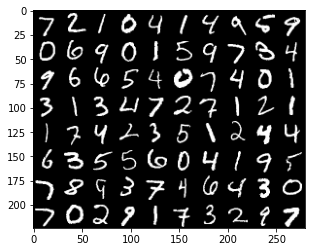

In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print('xtrain.shape',xtrain.shape)
print('ytrain.shape',ytrain.shape)
print('xtest.shape',xtest.shape)
print('ytest.shape',ytest.shape)

#wyswietlenie pierwszego przykladu
plt.imshow(xtest[0,:,:], cmap=plt.get_cmap('gray'))

#Wyswietlenie kilku pierwszych przykladow
rows = 8
cols = 10
counter = 0

images = None

for i in range(rows):
    current_row = None
    for j in range(cols):
        im = xtest[counter,:,:]
        counter = counter + 1
        if current_row is None:
            current_row = im
        else:
            current_row = np.hstack((current_row, im))
    if images is None:
        images = current_row
    else:
        images = np.vstack((images, current_row))
        
plt.figure()
plt.imshow(images, cmap=plt.get_cmap('gray'))

plt.show()

## Sieć typu MLP z jedną warstwą ukrytą w problemie MNIST

Sprawdzimy jak z problemem MNIST poradzi sobie sieć neuronowa typu MLP z jedną warstwą ukrytą. 

### Importy

In [14]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from keras.utils import np_utils

#W razie potrzeby zmien aktualny katalog
import os

path = '.'
os.chdir(path)

### Wczytanie danych
Zwróć uwagę, że dane są przechowywane jako 3-wymiarowy tensor.

In [15]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print('xtrain.shape',xtrain.shape)
print('ytrain.shape',ytrain.shape)
print('xtest.shape',xtest.shape)
print('ytest.shape',ytest.shape)

xtrain.shape (60000, 28, 28)
ytrain.shape (60000,)
xtest.shape (10000, 28, 28)
ytest.shape (10000,)


### Inicjalizacja ziarna (aby umożliwić powtarzalność obliczeń)

In [16]:
seed = 12345
np.random.seed(seed)

### Przygotowanie danych wejściowych

Oryginalne obrazy 28x28 pikseli będą podawane na warstwę wejściową sieci jako wektory o długości 784.

Dodatkowo, pozytywnie na proces uczenia sieci wpłynie normalizacja wartości pikseli z przedziału [0,255] na przedział [0,1].

In [17]:
inputs_num = xtrain.shape[1] * xtrain.shape[2] #liczba pikseli = liczba wejsc sieci
xtrain = xtrain.reshape(xtrain.shape[0], inputs_num).astype('float32')
xtest = xtest.reshape(xtest.shape[0], inputs_num).astype('float32')

# normalize inputs from 0-255 to 0-1
xtrain = xtrain / 255
xtest = xtest / 255

print(xtrain.shape)
print(xtest.shape)

(60000, 784)
(10000, 784)


### Zakodowanie informacji o klasach (żądane odpowiedzi 10-ciu neuronów wyjściowych)

In [18]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
num_classes = ytest.shape[1]

### Definiowanie i kompilacja modelu

In [19]:
model = Sequential()
model.add(Dense(500, input_dim=inputs_num, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Zapis do pliku najlepszego modelu

Podczas procesu uczenia możemy monitorować wybrane metryki i zapisywać do pliku aktualne modele sieci. Jest to przydatne dla dużych problemów, kiedy nauka sieci trwa bardzo długo i strata wyników w razie awarii jest przykrym doświadczeniem.

W poniższym przykładzie monitorujemy jakość klasyfikacji na zbiorze walidacyjnym i zapisujemy do pliku model, o ile jest on lepszy niż jakikolwiek wcześniejszy (tzn. z wcześniejszych epok).

__Uwaga__: Warto przed rozpoczęciem uczenia upewnić się, że mamy środowisko z GPU. 

In [20]:
logger = keras.callbacks.ModelCheckpoint('mnist_model_MLP.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True)

In [21]:
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=20, batch_size=200, verbose=2, callbacks=[logger])

Epoch 1/20
300/300 - 8s - loss: 0.3133 - accuracy: 0.9139 - val_loss: 0.1518 - val_accuracy: 0.9560
Epoch 2/20
300/300 - 1s - loss: 0.1290 - accuracy: 0.9628 - val_loss: 0.1016 - val_accuracy: 0.9691
Epoch 3/20
300/300 - 1s - loss: 0.0854 - accuracy: 0.9754 - val_loss: 0.0846 - val_accuracy: 0.9746
Epoch 4/20
300/300 - 1s - loss: 0.0634 - accuracy: 0.9817 - val_loss: 0.0717 - val_accuracy: 0.9779
Epoch 5/20
300/300 - 1s - loss: 0.0472 - accuracy: 0.9867 - val_loss: 0.0668 - val_accuracy: 0.9795
Epoch 6/20
300/300 - 1s - loss: 0.0362 - accuracy: 0.9902 - val_loss: 0.0607 - val_accuracy: 0.9813
Epoch 7/20
300/300 - 1s - loss: 0.0289 - accuracy: 0.9925 - val_loss: 0.0635 - val_accuracy: 0.9807
Epoch 8/20
300/300 - 1s - loss: 0.0225 - accuracy: 0.9944 - val_loss: 0.0595 - val_accuracy: 0.9810
Epoch 9/20
300/300 - 1s - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 10/20
300/300 - 1s - loss: 0.0125 - accuracy: 0.9976 - val_loss: 0.0617 - val_accuracy: 0.9816

### Ocena ostatecznego i najlepszego modelu

In [22]:
scores = model.evaluate(xtest, ytest, verbose=0)
print("Test error: %.2f%%" % (100-scores[1]*100))

#Wczytanie najlepszego modelu z pliku
model2 = load_model('mnist_model_MLP.hdf5')
scores2 = model2.evaluate(xtest, ytest, batch_size=200)
print('model z pliku:')
print("Test error: %.2f%%" % (100-scores2[1]*100))

Test error: 1.79%
50/50 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.9829
model z pliku:
Test error: 1.71%


## Najlepsze wyniki dla bazy MNIST 

Jak otrzymane wyniki mają się do najlepszych?

http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

## Sieci konwolucyjne

Aktualnie, jednymi z najlepszych modeli do analizy obrazów są sieci konwolucyjne.

Podstawą ich funkcjonowania są:

- warstwy konwolucyjne (współdzielenie wag między neuronami)
- warstwy typu MaxPooling (redukcja wymiarowości problemu)
- funkcje aktywacji typu ReLU
- regularyzacja, np. metodą Dropout

Popularnym modelem jest sieć konwolucyjna, w której pewna liczba warstw konwolucyjnych z funkcjami aktywacji ReLU występuje na przemian z warstwami MaxPooling. Po nich następuje jedna lub kilka warstw typu MLP (oznaczenie FC oznacza `Fully Connected`).

Często też pojawiają się warstwy implementujące strategie regularyzacji typu Dropout, które mają przeciwdziałać przeuczeniu się modelu.

![deep1.png](http://torus.uck.pk.edu.pl/~amarsz/images/deep1.PNG)

### Fukcja aktywacji ReLU

https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

$$f(x)=x^+=\max(x,0)$$

![deep2.png](http://torus.uck.pk.edu.pl/~amarsz/images/deep2.PNG)

### Warstwy konwolucyjne

Warstwa konwolucyjna to zestaw filtrów (neuronów), które skanują wszystkie kanały (ang. channels) wejściowego obrazu (trzy w poniższym przykładzie). Skanowanie oznacza, że wagi tego samego neuronu są używane wielokrotnie, co umożliwia ograniczenie liczby potrzebnych neuronów.

W poniższym przykładzie są dwa filtry o rozmiarze 3x3, zatem wyjściem tej warstwy konwolucyjnej będzie nowy obraz o dwóch kanałach (Output Volume).

![deep3.png](http://torus.uck.pk.edu.pl/~amarsz/images/deep3.PNG)
![deep4.png](http://torus.uck.pk.edu.pl/~amarsz/images/deep4.PNG)

### Warstwy Max Pooling

Warstwy Max Pooling mają za zadnie ograniczyć wymiarowość danych przekazywanych do kolejnych warstw. Z każdego wybranego obszaru (np. 2x2 piksele) wybierana jest wartość maksymalna. 

Zwróć uwagę, że pooling nie zmienia "głębokości" (liczby kanałów).

Przykładowo:

![deep5.png](http://torus.uck.pk.edu.pl/~amarsz/images/deep5.PNG)

## Realizacja prostej sieci konwolucyjne w bibliotece Keras

Projektowana sieć będzie miała tylko jedną warstwę konwolucyjną, po której wystąpi jedna ukryta warstwa typu MLP. Wyjściem całej sieci będzie kolejna warstwa typu `softmax`.

### Import i wczytanie danych

In [23]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import load_model
from keras.utils import np_utils

#import os
#path = '.'
#os.chdir(path)

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print('xtrain.shape',xtrain.shape)
print('ytrain.shape',ytrain.shape)
print('xtest.shape',xtest.shape)
print('ytest.shape',ytest.shape)

seed = 12345
np.random.seed(seed)

xtrain.shape (60000, 28, 28)
ytrain.shape (60000,)
xtest.shape (10000, 28, 28)
ytest.shape (10000,)


In [24]:
xtrain = xtrain.reshape(xtrain.shape[0], 28, 28, 1).astype('float32')
xtest = xtest.reshape(xtest.shape[0], 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
xtrain = xtrain / 255
xtest = xtest / 255

# one hot encode outputs
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
num_classes = ytest.shape[1]

In [25]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Trenowanie sieci

In [26]:
logger = keras.callbacks.ModelCheckpoint('mnist_model_CONV_SIMPLE.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True)

# Fit the model
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=20, batch_size=200, verbose=2, callbacks=[logger])

Epoch 1/20
300/300 - 31s - loss: 0.2402 - accuracy: 0.9313 - val_loss: 0.0819 - val_accuracy: 0.9756
Epoch 2/20
300/300 - 1s - loss: 0.0754 - accuracy: 0.9779 - val_loss: 0.0603 - val_accuracy: 0.9802
Epoch 3/20
300/300 - 1s - loss: 0.0545 - accuracy: 0.9832 - val_loss: 0.0422 - val_accuracy: 0.9860
Epoch 4/20
300/300 - 1s - loss: 0.0425 - accuracy: 0.9870 - val_loss: 0.0407 - val_accuracy: 0.9856
Epoch 5/20
300/300 - 1s - loss: 0.0356 - accuracy: 0.9890 - val_loss: 0.0338 - val_accuracy: 0.9891
Epoch 6/20
300/300 - 1s - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0338 - val_accuracy: 0.9895
Epoch 7/20
300/300 - 1s - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0343 - val_accuracy: 0.9887
Epoch 8/20
300/300 - 1s - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0318 - val_accuracy: 0.9902
Epoch 9/20
300/300 - 1s - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 10/20
300/300 - 1s - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0319 - val_accuracy: 0.989

### Testowanie modelu

In [27]:
scores = model.evaluate(xtest, ytest, verbose=0)
print("Test error: %.2f%%" % (100-scores[1]*100))

#Best model
model2 = load_model('mnist_model_CONV_SIMPLE.hdf5')
scores2 = model2.evaluate(xtest, ytest, batch_size=200)
print('model z pliku:')
print("Test error: %.2f%%" % (100-scores2[1]*100))

Test error: 1.04%
50/50 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9904
model z pliku:
Test error: 0.96%


## Większa sieć konwolucyjna

Porównaj dotychczasowe wyniki z wynikami następującej sieci. Odczytaj jej architekturę.

In [28]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import load_model
from keras.utils import np_utils

#import os
#path = '.'
#os.chdir(path)

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print('xtrain.shape',xtrain.shape)
print('ytrain.shape',ytrain.shape)
print('xtest.shape',xtest.shape)
print('ytest.shape',ytest.shape)

# fix random seed
seed = 12345
np.random.seed(seed)


xtrain = xtrain.reshape(xtrain.shape[0], 28, 28, 1).astype('float32')
xtest = xtest.reshape(xtest.shape[0], 28, 28, 1).astype('float32')

# normalize inputs from 0-255 to 0-1
xtrain = xtrain / 255
xtest = xtest / 255

# one hot encode outputs
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
num_classes = ytest.shape[1]

# define model
model = Sequential()
model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

logger = keras.callbacks.ModelCheckpoint('mnist_model_CONV_BIGGER.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True)

# Fit the model
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=20, batch_size=200, verbose=2, callbacks=[logger])

# Final evaluation of the model
scores = model.evaluate(xtest, ytest, verbose=0)
print("Test error: %.2f%%" % (100-scores[1]*100))

#Best model
model2 = load_model('mnist_model_CONV_BIGGER.hdf5')
scores2 = model2.evaluate(xtest, ytest, batch_size=200)
print('model z pliku:')
print("Test error: %.2f%%" % (100-scores2[1]*100))

print('end')

xtrain.shape (60000, 28, 28)
ytrain.shape (60000,)
xtest.shape (10000, 28, 28)
ytest.shape (10000,)
Epoch 1/20
300/300 - 4s - loss: 0.3896 - accuracy: 0.8762 - val_loss: 0.0770 - val_accuracy: 0.9764
Epoch 2/20
300/300 - 2s - loss: 0.0937 - accuracy: 0.9718 - val_loss: 0.0482 - val_accuracy: 0.9838
Epoch 3/20
300/300 - 1s - loss: 0.0696 - accuracy: 0.9784 - val_loss: 0.0356 - val_accuracy: 0.9877
Epoch 4/20
300/300 - 2s - loss: 0.0541 - accuracy: 0.9832 - val_loss: 0.0410 - val_accuracy: 0.9862
Epoch 5/20
300/300 - 1s - loss: 0.0475 - accuracy: 0.9852 - val_loss: 0.0356 - val_accuracy: 0.9879
Epoch 6/20
300/300 - 2s - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.0298 - val_accuracy: 0.9908
Epoch 7/20
300/300 - 2s - loss: 0.0360 - accuracy: 0.9884 - val_loss: 0.0266 - val_accuracy: 0.9910
Epoch 8/20
300/300 - 2s - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.0305 - val_accuracy: 0.9907
Epoch 9/20
300/300 - 2s - loss: 0.0331 - accuracy: 0.9897 - val_loss: 0.0286 - val_accuracy: 0.9911


## Porównanie modeli

In [30]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import load_model
from keras.utils import np_utils

#import os
#path = '.'
#os.chdir(path)

print(tf.__version__)
print(keras.__version__)

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print('xtrain.shape',xtrain.shape)
print('ytrain.shape',ytrain.shape)
print('xtest.shape',xtest.shape)
print('ytest.shape',ytest.shape)

xtrain = xtrain.reshape(xtrain.shape[0], 784).astype('float32')
xtest = xtest.reshape(xtest.shape[0], 784).astype('float32')

# normalize inputs from 0-255 to 0-1
xtrain = xtrain / 255
xtest = xtest / 255

# one hot encode outputs
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)

#Porownanie sieci

#Siec MLP
model = load_model('mnist_model_MLP.hdf5')
scores = model.evaluate(xtest, ytest, batch_size=200)
print("Test error (Model MLP): %.2f%%" % (100-scores[1]*100))


xtrain = xtrain.reshape(xtrain.shape[0], 28, 28, 1).astype('float32')
xtest = xtest.reshape(xtest.shape[0], 28, 28, 1).astype('float32')

#Siec konwolucyjna mala
model = load_model('mnist_model_CONV_SIMPLE.hdf5')
scores = model.evaluate(xtest, ytest, batch_size=200)
print("Test error (Model CONV SIMPLE): %.2f%%" % (100-scores[1]*100))

#Siec konwolucyjna wieksza
model = load_model('mnist_model_CONV_BIGGER.hdf5')
scores = model.evaluate(xtest, ytest, batch_size=200)
print("Test error (Model CONV BIGGER): %.2f%%" % (100-scores[1]*100))

print('end')

2.5.0
2.5.0
xtrain.shape (60000, 28, 28)
ytrain.shape (60000,)
xtest.shape (10000, 28, 28)
ytest.shape (10000,)
50/50 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.9829
Test error (Model MLP): 1.71%
50/50 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9904
Test error (Model CONV SIMPLE): 0.96%
50/50 [==============================] - 1s 4ms/step - loss: 0.0239 - accuracy: 0.9931
Test error (Model CONV BIGGER): 0.69%
end


&copy; Katedra Informatyki, Politechnika Krakowska